In [1]:
#standard ML/Image Processing imports
import numpy as np
import pandas as pd
import math, pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

#pytorch imports
import torch
import torch.optim as optim
import torchvision.models as models

from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# no one likes irrelevant warnings
import warnings  
warnings.filterwarnings('ignore')

from image_classification_file import ImageFolderWithPathsAndRatings, ImageFolderWithPaths

In [2]:
"""
SCRIPT GLOBAL VARS
"""
# root directory where the images are stored
data_dir = "/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump"#/Fall"#/Dump"
# ratings = None
limit_num_pictures = False #limit_num_pictures = 2000
rated_indices = []
ratings = []
bad_indices = []
# we load the pretrained model, the argument pretrained=True implies to load the ImageNet weights for the pre-trained model
vgg16 = models.vgg16(pretrained=True)

In [3]:
_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_size = 0.2 # percentage of data to use for test set

# load data and apply the transforms on contained pictures
train_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)
test_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)   

num_pictures = len(train_data)
print("Number of pictures in subdirectories: {}".format(num_pictures))

# Shuffle pictures and split training set
indices = list(range(num_pictures))
print("Head of indices: {}".format(indices[:10]))

split = int(np.floor(valid_size * num_pictures))
print("Split index: {}".format(split))

# may be unnecessary with the choice of sampler below
np.random.shuffle(indices)
print("Head of shuffled indices: {}".format(indices[:10]))

train_idx, test_idx = indices[split:], indices[:split] #rated_indices, bad_indices
print("Size of training set: {}, size of test set: {}".format(len(train_idx), len(test_idx)))

# Define samplers that sample elements randomly without replacement
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define data loaders, which allow batching and shuffling the data
train_loader = torch.utils.data.DataLoader(train_data,
            sampler=train_sampler, batch_size=1)#, num_workers=4)
print("Train loader length: {}".format(len(train_loader)))
test_loader = torch.utils.data.DataLoader(test_data,
            sampler=test_sampler, batch_size=1)#, num_workers=4)
print("Test loader length: {}".format(len(test_loader)))

# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device that will be used: {}".format(device))

vgg16.to(device) # loads the model onto the device (CPU or GPU)

Number of pictures in subdirectories: 69704
Head of indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Split index: 13940
Head of shuffled indices: [65041, 15486, 21556, 29030, 2961, 57852, 40011, 57274, 12572, 45210]
Size of training set: 55764, size of test set: 13940
Train loader length: 55764
Test loader length: 13940
Device that will be used: cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
for param in vgg16.parameters():
    param.requires_grad = False #freeze all convolution weights
network = list(vgg16.classifier.children())[:-1] #remove fully connected layer
network.extend([nn.Linear(4096, 10)]) #add new layer of 4096->100 (rating scale with 1 decimal - similar to 1 hot encoding)
vgg16.classifier = nn.Sequential(*network)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(vgg16.parameters(), lr=0.4, momentum=0.9) # optimizer

vgg16 #print out the model to ensure our network is correct

vgg16.load_state_dict(torch.load('models/Jan29_All_AVA_only_training.pt'))

<All keys matched successfully>

In [5]:
# limit_num_pictures = 13940
# vgg16.eval()

# print(len(test_loader))

# for i, data in enumerate(test_loader):
#     if limit_num_pictures:
#         if i > limit_num_pictures:
#             break
#     # inputs, _, path, label = data
#     inputs, _, _, _ = data
#     # print(label)
#     output = vgg16(inputs)
#     # loss = criterion(output, label)

#     # running_loss += loss.item()
#     _, preds = torch.max(output.data, 1)
#     print(preds)
#     # num_correct += (preds == label).sum().item()
#     print("Classification for test image #{}: {}".format(i, output))


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ928.JPG
Classification for test image #0: [-827.783203125, 1033.79248046875, -10242.484375, 1850.734130859375, 15387.3583984375, 8416.6171875, -4668.9296875, -10926.6494140625, 1823.7578125, -1845.5728759765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


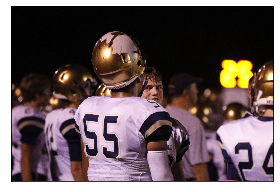


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171014_Rugby_ColumbiaOutlaws_jd/20171014_ColumbiaOutlaws_JD_026.JPG
Classification for test image #1: [-8464.63671875, -2697.44189453125, -2160.7578125, 18453.83203125, 10943.1181640625, 3948.925537109375, -18525.6640625, -3551.0625, 101.77009582519531, 1950.989990234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170922_hookah_JJ/20170922_hookah_JJ_042.JPG
Classification for test image #2: [5048.52978515625, -1157.067626953125, 462.01336669921875, 3114.911376953125, 5805.7138671875, -1878.834716796875, -7548.1083984375, -3332.59033203125, -404.1191711425781, -110.32030487060547]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170830_RockbridgeSoccer_jd/20170830_RockbridgeSoccer_jd_364.JP


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_361.JPG
Classification for test image #20: [-2677.1396484375, 833.007080078125, -2856.09228515625, 5680.33203125, 11841.953125, 3045.216552734375, -3666.072998046875, -8506.865234375, 344.67108154296875, -4039.23193359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


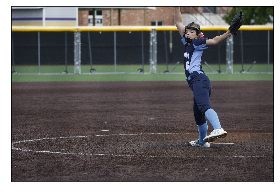


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171025_MKT_FH_EJ/20171025_MKT_FH_EJ_007.JPG
Classification for test image #21: [-2716.184326171875, -2197.112060546875, -2012.6217041015625, 2823.2529296875, 16935.2421875, 4470.390625, -8898.1044921875, -4420.201171875, -2131.091552734375, -1852.70947265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171202_veteransunited_nc/20171202_Vox_veteransunited_NC_010.JPG
Classification for test image #22: [146.90805053710938, -1752.8436279296875, -2038.8116455078125, 2634.02978515625, 17988.236328125, 1878.286865234375, -5979.203125, -6644.35791015625, -1405.882080078125, -4824.80029296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170921_hickmanvolleyball_nc/20170921_hickmanvolleyball_nc

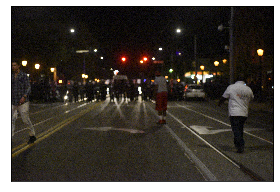


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170830_HickmanFBPractice_EJ/20170830_HickmanFBPractice_EJ_085.JPG
Classification for test image #41: [-1621.16357421875, -2762.59521484375, -9296.6455078125, -1705.32080078125, 13768.1650390625, 2154.904541015625, -1583.270751953125, -403.40032958984375, 1038.96337890625, 410.6098937988281]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171116_muwbb_Ec/20171116_muwbb_ec_488.JPG
Classification for test image #42: [-4163.21630859375, 1127.2686767578125, -5614.15869140625, 4336.51904296875, 23047.609375, 9741.0703125, -14526.4033203125, -11118.6806640625, 606.2479858398438, -3436.91748046875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_188.JPG
Cla


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171012_battlefootballpracticefeature_nc/20171012_battlefootballpracticefeature_nc_017.JPG
Classification for test image #60: [-5320.6689453125, -4064.86572265625, -2199.08984375, -2741.680908203125, 24189.783203125, 8041.24609375, -13762.029296875, -3416.96435546875, 1792.635986328125, -2519.68701171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


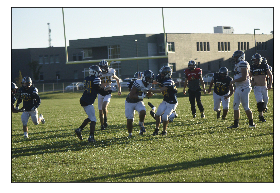


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170821_Eclipse_jd/20170821_Eclipse_CoopersLanding_jd_203.JPG
Classification for test image #61: [-4023.956787109375, -4005.967041015625, -4633.4296875, 5443.98095703125, 20853.03515625, 2357.656982421875, -6001.2998046875, -5990.33837890625, -3366.3134765625, -631.8641967773438]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170823_gradrally_EJ/20170823_gradrally_EJ151.JPG
Classification for test image #62: [-593.6820068359375, 1294.5228271484375, -3201.55712890625, 5599.607421875, 9118.1748046875, -2105.8837890625, -2587.5986328125, -6043.36669921875, -99.989990234375, -1381.1661376953125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170920_toltongolf_EJ/20170920_toltongolf_EJ_077.JPG
Cl


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170823_BattleSoftball_OL/20170823_Battlesoftball_OL_463.JPG
Classification for test image #80: [-4080.161865234375, -1330.729736328125, -1579.7491455078125, 1061.5452880859375, 23022.49609375, -3098.9599609375, -6338.8154296875, -6353.685546875, 780.1021118164062, -2083.5283203125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


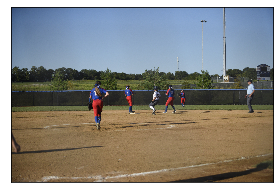


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_802.JPG
Classification for test image #81: [-3973.247314453125, -1818.1895751953125, 619.00537109375, 6332.8330078125, 9970.4306640625, 6536.31640625, -10296.4638671875, -6001.93212890625, 1279.1627197265625, -2648.986083984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170823_BattleHSFootballPractice_jd/20170823_BattlefootballPractice_jd_0042.JPG
Classification for test image #82: [424.8373107910156, 2581.88671875, -2117.490478515625, 3349.947998046875, 17743.66015625, -1513.94775390625, -11856.873046875, -6567.99951171875, 2058.621337890625, -4101.25]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PetExpo_OL/20170826_PetExpo_OL_180


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170823_gradrally_EJ/20170823_gradrally_EJ331.JPG
Classification for test image #100: [-862.26953125, 424.14019775390625, -1267.086181640625, 5899.48486328125, 9772.359375, 6208.890625, -7552.9697265625, -7971.5771484375, -61.43964767456055, -4588.95263671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


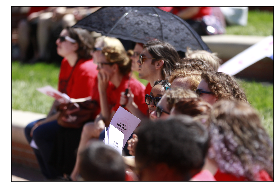


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_092.JPG
Classification for test image #101: [-1798.80712890625, 831.2738647460938, 626.8311767578125, 2971.906005859375, 9316.7060546875, 1094.254638671875, -6150.6533203125, -3299.5009765625, -1393.824951171875, -2198.456787109375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170912_Toltonsoftball_ec/20170912_toltonsoftball_ec_091.JPG
Classification for test image #102: [1280.561767578125, 410.59393310546875, -8256.3837890625, -7740.8076171875, 15581.9423828125, 6191.021484375, -713.230712890625, -9640.107421875, 4499.1728515625, -1613.8353271484375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171209_KwanzaaCele


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_429.JPG
Classification for test image #120: [738.7393798828125, 478.2530517578125, -1947.6800537109375, 8609.6396484375, 7350.4482421875, 920.911865234375, -7396.1220703125, -6269.65771484375, -605.1610717773438, -1878.0408935546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


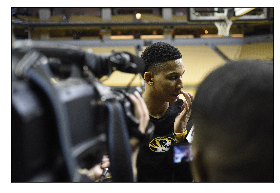


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171005_rbvb_nc/20171005_rbvb_nc_097.JPG
Classification for test image #121: [-6534.92041015625, 257.20947265625, -3774.566650390625, 17579.51953125, 22038.310546875, 4610.134765625, -17154.08203125, -12490.7333984375, 1563.1934814453125, -6092.74267578125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171116_muwbb_Ec/20171116_muwbb_ec_135.JPG
Classification for test image #122: [-6446.33251953125, -846.115966796875, -1324.4237060546875, 10785.9453125, 20900.787109375, 3413.113037109375, -13762.3857421875, -7140.41455078125, 241.83351135253906, -5822.54052734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_1461.JPG
Classification for 


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170915_stlouisprotest_ec/20170915_STLOUISPROTEST_ec_158.JPG
Classification for test image #140: [5.434295654296875, -2146.95556640625, 193.06765747070312, 3482.487548828125, 16008.2138671875, 125.489990234375, -13746.103515625, -672.3565063476562, -897.3326416015625, -2350.777587890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


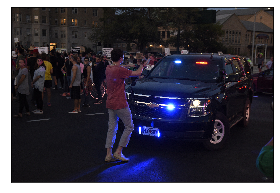


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171009_welders_nc/20171009_welding_nc_150.JPG
Classification for test image #141: [-1768.357177734375, 714.507080078125, -3038.94580078125, 7533.3779296875, 15728.5947265625, -718.246826171875, -5122.4501953125, -7412.07666015625, -1173.7288818359375, -4742.5458984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ253.JPG
Classification for test image #142: [-1039.1463623046875, -390.0526123046875, -9374.7236328125, 1544.4354248046875, 20260.865234375, -160.645263671875, -510.3448486328125, -8856.18359375, 1325.350341796875, -2800.751220703125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/zz_Mugs/20170820_MissourianMugs_WM_251.JPG
Classification for test imag


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170831_HickmanSoftball_OL/20170831_HickmanSoccer_OL_353.JPG
Classification for test image #160: [-3981.816162109375, 1187.0582275390625, -4062.73095703125, -4758.6220703125, 5458.697265625, 14109.513671875, -1816.178955078125, -6376.01904296875, 1206.3668212890625, -966.9063110351562]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


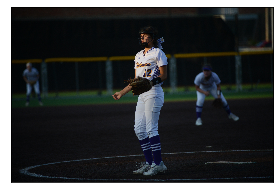


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171207_rbhoops_ec/20171207_rbhoops_ec_040.JPG
Classification for test image #161: [-1047.1602783203125, -1498.7032470703125, 795.749267578125, 3406.15966796875, 9381.578125, 1589.433349609375, -8277.2958984375, -3526.24853515625, 286.1107177734375, -1109.255859375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_815.JPG
Classification for test image #162: [-2809.296630859375, -373.66961669921875, -3094.39013671875, 2915.926513671875, 15486.263671875, 5692.236328125, -10367.412109375, -6991.93994140625, 3367.362060546875, -3826.450439453125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_Tolton


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170823_BattleHSFootballPractice_jd/20170823_BattlefootballPractice_jd_0030.JPG
Classification for test image #180: [2692.52294921875, -1445.183837890625, -4250.56201171875, 5243.1494140625, 20332.861328125, 919.008544921875, -8634.5771484375, -11360.3828125, -834.9436645507812, -2659.22509765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


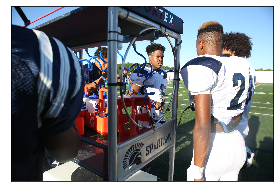


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_314.JPG
Classification for test image #181: [-5056.23291015625, 1766.4466552734375, -3306.9345703125, 1314.65576171875, 10099.3564453125, 6566.4443359375, -5442.603515625, -6732.9912109375, 754.5489501953125, 38.67388916015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171005_allypanel_nc/20171005_allypanel_nc_020.JPG
Classification for test image #182: [-55.594940185546875, 549.9060668945312, -1770.142333984375, 2722.28369140625, -21.77783203125, 9718.0146484375, -2549.12255859375, -3921.64990234375, -1010.13671875, -3660.1533203125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171126_kerripolicy_JJ/20171126_kerripolicy_JJ_088.JPG
Classification for test image #200: [-1660.391357421875, -1739.08056640625, -194.82919311523438, 1209.161376953125, 8004.3447265625, 9999.267578125, -10057.337890625, -4015.168701171875, -1697.7445068359375, 153.29776000976562]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


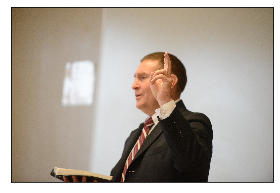


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_OL/20170907_ShawnVeronica_OL_694.JPG
Classification for test image #201: [-233.18533325195312, -263.5489501953125, 1519.476806640625, 5951.5859375, -733.10595703125, 804.167236328125, -6253.576171875, -2226.365234375, 714.4838256835938, 720.831298828125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ1238.JPG
Classification for test image #202: [-5941.13427734375, -4851.78466796875, -8536.9765625, -469.299560546875, 24661.873046875, 13011.353515625, -14691.76953125, -5781.95263671875, 1772.4136962890625, 825.2562866210938]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171013_craftbeer_JJ_VOX/20171013_craftbeer_JJ_VOX_033.JPG


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170830_RockbridgeSoccer_jd/20170830_RockbridgeSoccer_jd_307.JPG
Classification for test image #220: [-5436.43798828125, 641.5568237304688, 1577.134765625, 1960.9228515625, 16790.951171875, 4648.31640625, -6613.7734375, -7370.50830078125, -769.8551635742188, -5428.49072265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


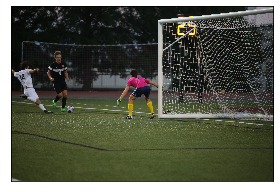


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171008_crushfestival_JJ/20171008_crushfestival_JJ_116.JPG
Classification for test image #221: [-1761.8065185546875, -465.573974609375, -2898.65380859375, 13982.083984375, 19519.28515625, -418.6513671875, -11343.357421875, -10537.134765625, -2138.3291015625, -3937.23779296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170912_Toltonsoftball_ec/20170912_toltonsoftball_ec_064.JPG
Classification for test image #222: [1062.434326171875, -234.7053985595703, -9810.4423828125, 2304.28515625, 14160.1689453125, 2653.252685546875, -3797.180908203125, -6270.9921875, 1604.4532470703125, -1669.8170166015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonFootballPractice_OL/20170906_ToltonFootballPractice_OL_092.JPG
Classification for test image #240: [199.48580932617188, 23.480361938476562, 507.5851135253906, 7314.310546875, 21029.009765625, -7046.2255859375, -19217.703125, -4767.04638671875, 1679.1451416015625, 276.5480651855469]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


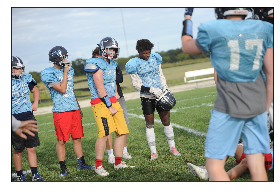


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_626.JPG
Classification for test image #241: [3437.129150390625, 2259.79541015625, 3166.95068359375, 4107.7705078125, 14893.7822265625, 1903.772216796875, -15928.9658203125, -6717.4306640625, -2038.8326416015625, -5083.66943359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171110_GirlsOnTheRun_EJ/20171111_GirlsOnTheRun_EJ_042.JPG
Classification for test image #242: [-2421.570556640625, 2502.6611328125, 97.68502807617188, 20272.283203125, 18349.240234375, -8756.75, -14584.6845703125, -10025.494140625, -1716.2430419921875, -3716.765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_564.JPG
Classificat


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170924_DDfarm_JJ/20170924_DDfarm_JJ_214.JPG
Classification for test image #260: [-1151.4490966796875, -2257.516845703125, -5169.48291015625, 1190.02490234375, 6129.6484375, 12789.796875, 154.10205078125, -7788.59912109375, -2248.705078125, -1646.1961669921875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


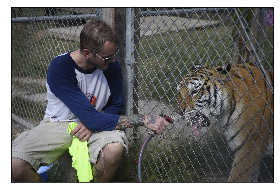


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_450.JPG
Classification for test image #261: [-457.7398376464844, -241.60743713378906, -4151.60986328125, -1882.528564453125, 17869.58984375, 7161.2529296875, -10702.0556640625, -5520.40576171875, -1692.2725830078125, -382.0638122558594]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171113_InHomeImpact_EJ/20171113_InHomeImpact_EJ_153.JPG
Classification for test image #262: [75.46139526367188, 2142.47021484375, 1147.4063720703125, 15052.7626953125, 5382.60009765625, -3446.54345703125, -9721.1953125, -7850.48876953125, -197.71446228027344, -2583.45556640625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_Stephens


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171025_Rockclimbing_ec/20171025_rockclimbing_159.JPG
Classification for test image #280: [-5257.14208984375, -1998.4290771484375, -8370.9140625, -474.875244140625, 4928.4267578125, 13707.701171875, -527.129638671875, -212.4178466796875, -2357.72802734375, 563.5293579101562]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


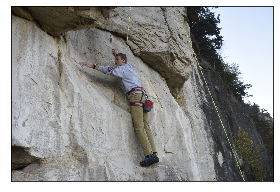


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_486.JPG
Classification for test image #281: [-1332.2686767578125, -2614.04541015625, -2030.1226806640625, 10560.1748046875, 12200.2919921875, 5669.6962890625, -11578.443359375, -6071.38671875, -2816.90380859375, -1986.948486328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_TigersForTigers_EJ/20171028_TigersForTigers_EJ_027.JPG
Classification for test image #282: [-1024.80908203125, -3594.08203125, -1954.7276611328125, 7313.4384765625, 12232.7470703125, -6497.9306640625, -4315.5458984375, 747.2462768554688, -2231.664306640625, -673.0309448242188]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171009_welders_nc/20171009_welding_nc_120.JPG
Classification for test image #300: [-3160.164794921875, -1566.5574951171875, -2746.816162109375, 14965.8935546875, 7688.2158203125, 153.201904296875, -4981.85546875, -6457.02880859375, -1459.8255615234375, -2435.296142578125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


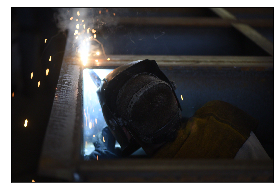


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170821_Eclipse_jd/20170821_Eclipse_CoopersLanding_jd_071.JPG
Classification for test image #301: [-4624.20068359375, -1713.3956298828125, -738.997802734375, -343.137939453125, 9494.26953125, 1557.524658203125, -1250.8076171875, -3001.317626953125, -964.986083984375, 1584.638671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170830_RockbridgeSoccer_jd/20170830_RockbridgeSoccer_jd_190.JPG
Classification for test image #302: [-5999.40283203125, -400.565673828125, -3242.643310546875, 15376.9794921875, 16268.0224609375, -811.380615234375, -11777.90625, -8632.904296875, 1289.3067626953125, -2069.044677734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171203_nightbball_JJ/20171203_normstew


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_19.JPG
Classification for test image #320: [1909.98974609375, -518.5521850585938, -1930.3997802734375, 2803.99560546875, 7005.13671875, 656.380126953125, -4927.912109375, -1742.570068359375, -619.8812866210938, -2635.148681640625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


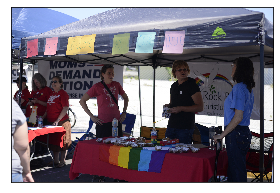


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170928_hallsvillecarnival_nc/20170928_hallsvillecarnival_nc_170.JPG
Classification for test image #321: [3345.99951171875, -2416.201171875, 4038.22314453125, 11138.87890625, 14986.4814453125, -4302.5205078125, -12102.921875, -9793.69140625, -1866.86865234375, -3027.085205078125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170830_HickmanFBPractice_EJ/20170830_HickmanFBPractice_EJ_252.JPG
Classification for test image #322: [1448.0587158203125, 2167.4169921875, -1187.298095703125, 1884.52734375, 8748.28125, -2555.503173828125, -3257.450439453125, -6904.08447265625, 2752.750244140625, -3095.73583984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170831_HickmanSoftball_OL/20170831_HickmanS


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171013_helicoptertraining_JJ/20171013_helicoptertraining_JJ_274.JPG
Classification for test image #340: [167.57296752929688, -2853.58056640625, -5300.1162109375, 1182.3543701171875, 20056.990234375, 7769.556640625, -11371.90234375, -3522.075927734375, -1373.185791015625, -4753.29345703125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


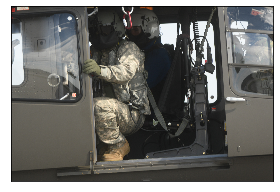


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_557.JPG
Classification for test image #341: [-5384.22802734375, -4234.02978515625, -2403.058349609375, 5096.017578125, 5745.0908203125, 1012.566162109375, 2362.456787109375, -4033.5634765625, 273.0024108886719, 1566.482177734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_277.JPG
Classification for test image #342: [-3137.676025390625, -86.50154113769531, -206.39657592773438, 4753.87939453125, 16597.955078125, -4279.8076171875, -8467.927734375, -3171.337890625, 635.0012817382812, -2636.41650390625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170825_Douglass_JJ/20170825_Douglas_JJ_030.JPG
Clas


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171009_PaigeBedsworth_EJ/20171009_PaigeBedsworth_EJ_1331.JPG
Classification for test image #360: [-1520.85888671875, 789.0731811523438, -1857.4659423828125, -4342.2705078125, 12857.3642578125, 3679.468017578125, -3707.482421875, -3768.13232421875, 728.6416015625, -2858.856689453125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


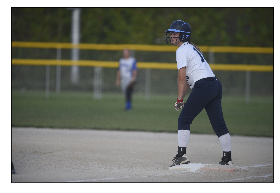


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ223.JPG
Classification for test image #361: [4937.99853515625, 1627.4146728515625, -4482.51220703125, 8506.1181640625, 10213.5751953125, -2359.01708984375, -10448.54296875, -5952.46240234375, 1331.890625, -3374.166259765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_503.JPG
Classification for test image #362: [-891.479248046875, -844.7679443359375, -7156.91650390625, 6650.6162109375, 7716.115234375, 6927.201171875, -6366.1923828125, -3986.8740234375, 664.0610961914062, -2711.793701171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171026_musoc_nc/20171026_musoc_nc_129.J


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_499.JPG
Classification for test image #380: [1278.32568359375, 736.3677978515625, -3633.6103515625, 21200.837890625, 8406.509765625, 915.603759765625, -10316.8271484375, -13265.767578125, -2264.4228515625, -3055.81787109375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


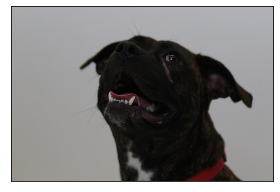


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170921_hickmanvolleyball_nc/20170921_hickmanvolleyball_nc_150.JPG
Classification for test image #381: [4465.703125, 1291.4576416015625, 2923.03564453125, 7121.326171875, 19436.240234375, -2589.7783203125, -15132.1396484375, -17276.23046875, 1512.5830078125, -1751.9033203125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171031_BruceWallace_ec/20171031_BruceWallace_ec_173.JPG
Classification for test image #382: [3013.945556640625, 79.53157043457031, 1974.264404296875, 6836.8095703125, 3636.57275390625, 9552.361328125, -14119.599609375, -4165.23681640625, -2054.036865234375, -4752.708984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_5


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171115_PJP_Shoot2_EJ/20171115_PJP_Shoot2_EJ_070.JPG
Classification for test image #400: [3147.458740234375, -2256.117919921875, -4095.23583984375, -375.80908203125, 12483.6298828125, 153.186279296875, -5375.6953125, -1904.902587890625, 182.3555908203125, -1956.0767822265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


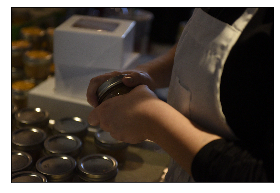


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_301.JPG
Classification for test image #401: [-4923.65625, -291.0654296875, -10395.5517578125, 9409.7900390625, 5567.142578125, 9807.0078125, -6969.38671875, -3680.7119140625, 268.49005126953125, 1207.70068359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_185.JPG
Classification for test image #402: [1028.2000732421875, 2048.4404296875, -1061.9090576171875, 9649.2236328125, 8477.4384765625, -1479.267578125, -12267.1474609375, -5195.2080078125, -213.85958862304688, -984.923583984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170915_MUSoccer_OL/20170915_MUSoccer_OL_187.JPG
Classificati


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170917_boonevilleservice_JJ/20170917_boonvilleservice_JJ_380.JPG
Classification for test image #420: [1582.1395263671875, -1162.5445556640625, -2682.82275390625, -602.574462890625, 13945.5244140625, 13118.326171875, -9136.419921875, -10523.119140625, -1572.786376953125, -2963.802978515625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


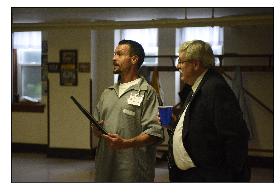


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170922_Twiddlemuffs_JJ/20170922_twiddlemuffs_JJ_054.JPG
Classification for test image #421: [2265.592041015625, -649.087158203125, 420.1248474121094, 10629.5166015625, 13235.1083984375, -6690.8017578125, -11205.2861328125, -3270.974365234375, -1008.8790893554688, -3724.705078125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170916_Tailgate_OL/20170916_Tailgating_OL_193.JPG
Classification for test image #422: [-1209.668212890625, 589.9547119140625, -1734.689453125, 8235.40625, 16638.447265625, -6132.349609375, -10421.9384765625, -3279.480224609375, 323.8000793457031, -3010.6875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171002_toltonsoftball_EJ/20171002_toltonsoftball_EJ_326.JPG
Class


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171110_GirlsOnTheRun_EJ/20171111_GirlsOnTheRun_EJ_310.JPG
Classification for test image #440: [-374.1577453613281, -75.33258056640625, -971.9376220703125, 3135.541015625, 25137.845703125, -4223.900390625, -12328.083984375, -5121.18994140625, -1958.0712890625, -3220.1435546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


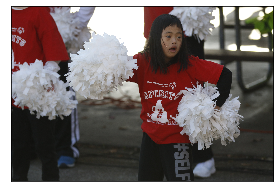


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170821_EclipseI70_EJ/20170821_EclipseI70_EJ_011.JPG
Classification for test image #441: [-3847.214599609375, -2037.7794189453125, -4355.02587890625, 6155.34912109375, 15452.2392578125, 3614.156982421875, -8909.7314453125, -4878.35009765625, 0.21410751342773438, -1193.59228515625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170920_MUVolleyball_OL/20170920_MUVolleyball_OL_572.JPG
Classification for test image #442: [-4835.95166015625, 2293.68212890625, -2194.58544921875, 21119.638671875, 5434.8408203125, 7329.2255859375, -14744.1025390625, -11838.9462890625, 128.41925048828125, -2690.9111328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_Hickmanboyssoccer_ec/20170829_hickmans


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171209_KwanzaaCelebration_EJ/20171209_KwanzaaCelebration_EJ_127.JPG
Classification for test image #460: [3464.884033203125, 1565.4620361328125, -6907.54248046875, -598.496337890625, 4280.35546875, 2524.544677734375, -641.8818359375, -3694.769287109375, 1750.71533203125, -1740.293212890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


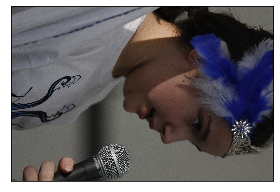


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171109_drinkingwater_nc/20171109_drinkingwater_nc_006.JPG
Classification for test image #461: [1620.052001953125, 1.9505767822265625, 561.117919921875, 3172.48046875, 5336.919921875, 2987.790771484375, -4796.3447265625, -6079.12548828125, -374.27947998046875, -2429.546630859375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171030_featurehunt_nc/20171031_featurehunt_nc_037.JPG
Classification for test image #462: [-9870.95703125, -936.1555786132812, -4302.0576171875, -5067.4775390625, 25947.41796875, 8345.126953125, -11195.13671875, 4613.5166015625, -2641.556884765625, -4892.896484375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170910_steamengineshow_jj/20170910_steamengineshow_jj_233.


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171002_toltonsoftball_EJ/20171002_toltonsoftball_EJ_394.JPG
Classification for test image #480: [-4326.7373046875, -1586.8280029296875, -10452.8681640625, 1400.5089111328125, 6209.4736328125, 8420.83984375, 5516.728515625, -7318.8212890625, 1253.3336181640625, 883.7840576171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


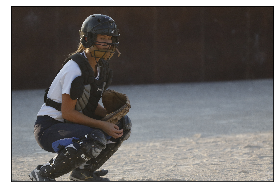


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_714.JPG
Classification for test image #481: [2764.956298828125, -2927.88427734375, -4409.14990234375, 6835.728515625, 11753.6796875, -4618.92724609375, -6098.6044921875, -4854.57080078125, 923.8955078125, 631.8248291015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171014hickmansoccer/20171014_hickmansoccer_jj_238.JPG
Classification for test image #482: [-3542.808837890625, 135.1577911376953, -4768.32373046875, -1747.28564453125, 13428.9423828125, 3520.780517578125, -4989.578125, -1625.013916015625, 865.1070556640625, -1276.554443359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171024_academyofrock_ec/20171024_academyofrock_ec_220.JPG



Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_477.JPG
Classification for test image #500: [337.4413757324219, -555.4307861328125, -2404.33203125, 9370.369140625, 14264.05859375, -320.734619140625, -12854.796875, -5268.84912109375, -683.5087890625, -1883.660400390625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


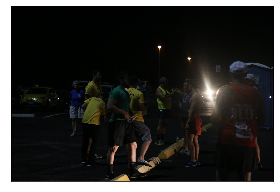

In [6]:
limit_num_pictures = 500
vgg16.eval() # set to prediction mode
testing_loss = 0
testing_accuracy = 0
running_loss = 0.0
num_correct = 0

ratings_data = None
for i, data in enumerate(test_loader, 0):
    
    if limit_num_pictures:
        if i > limit_num_pictures:
            break
    inputs, _, path, label = data
    path = path[0]
    label = torch.LongTensor([int(label[0])])

    output = vgg16(inputs)
    loss = criterion(output, label)

    running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    num_correct += (preds == label).sum().item()
    ratings = output[0].tolist()
    print("\nImage path: {}".format(path))
    print("Classification for test image #{}: {}".format(i, ratings))
    tuple_to_insert = {}
    for n in range(8):
        tuple_to_insert[str(n + 1)] = [ratings[n]]
    tuple_to_insert['file_path'] = [path]
    tuple_to_insert = pandas.DataFrame.from_dict(tuple_to_insert)

    if i == 0:
        ratings_data = tuple_to_insert
    else:
        ratings_data = ratings_data.append(tuple_to_insert, ignore_index=True)
    print(ratings_data.tail(0))
    if i % 20 == 0:
        fig = plt.figure(figsize=(16, 4))
        columns = 3
        rows = 1
        img = mpimg.imread(path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

testing_loss = running_loss/len(test_loader.dataset)
testing_accuracy = 100. * num_correct/len(test_loader.dataset)
ratings_data = ratings_data.set_index('file_path')


In [7]:
# ratings_data.set_index('file_path')
ratings_data

1            2  \
file_path                                                                      
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -827.783203  1033.792480   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -8464.636719 -2697.441895   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  5048.529785 -1157.067627   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -6535.872559  -346.666931   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -1639.702515  -948.662964   
...                                                         ...          ...   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  2502.754639  1875.385620   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -1052.575806 -2301.501221   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -958.577393  -229.068222   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -9469.623047 -2631.975586   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   337.441376  -555.430786   

                                                               3  \
file_path                                                          
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -10242.484375   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -2160.757812   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...    462.013367   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -1788.559082   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -9084.333008   
...                                                          ...   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   2607.016113   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -1837.023193   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   -436.084930   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -1801.735962   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -2404.332031   

                                                               4  \
file_path                                                          
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   1850.734131   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  18453.832031   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   3114.911377   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -2843.534424   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -2012.607178   
...                                                          ...   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  13585.749023   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  13589.208008   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   7814.360352   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   8305.306641   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   9370.369141   

                                                               5            6  \
file_path                                                                       
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  15387.358398  8416.617188   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  10943.118164  3948.925537   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   5805.713867 -1878.834717   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  21404.912109  4641.982422   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  17477.263672  9604.087891   
...                                                          ...          ...   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  21317.576172 -1846.531982   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  19807.980469 -1793.095947   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  23711.556641   883.211670   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  29019.509766 -8459.710938   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  14264.058594  -320.734619   

                                                               7             8  
file_path                                                                       
/mnt/md0/mysql-dump-economists/Arch

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f583ac50b10>,
      dtype=object)

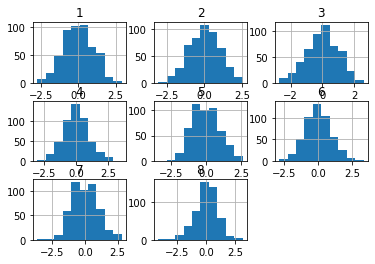

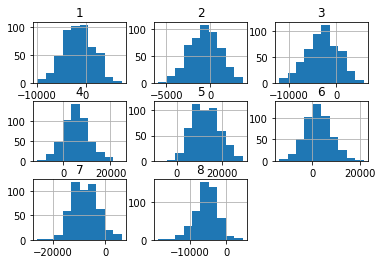

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
space_1 = scaler.fit_transform(ratings_data)
ratings_data_norm = pd.DataFrame(space_1, columns=ratings_data.columns, index=ratings_data.index)
ratings_data_norm.hist()
ratings_data.hist()

In [9]:
ratings_data_norm['classification'] = ratings_data_norm.idxmax(axis=1)
ratings_data_norm = ratings_data_norm.sort_values(by=['classification'])
ratings_data_norm
bad_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '8']
good_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '1']

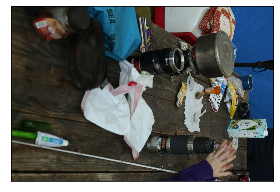

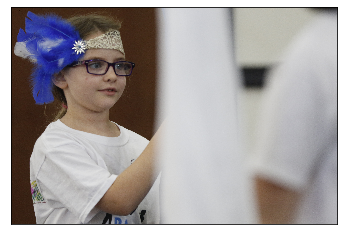

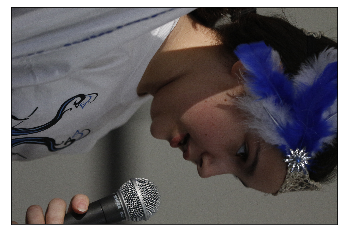

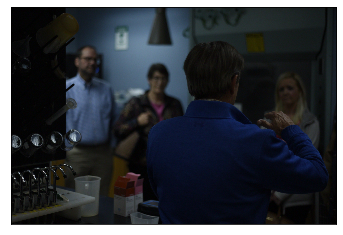

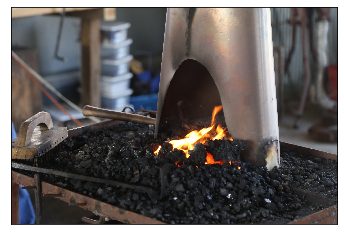

In [10]:
fig = plt.figure(figsize=(16, 4))
for path in good_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

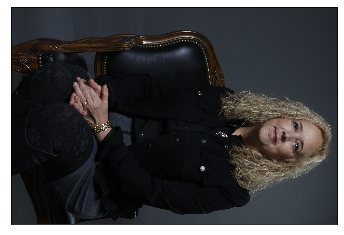

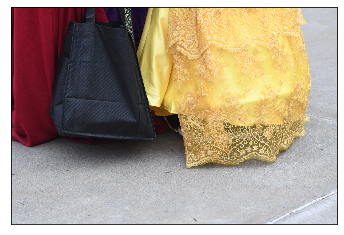

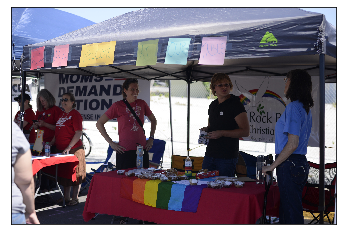

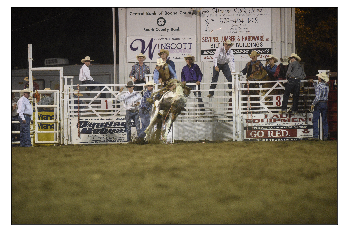

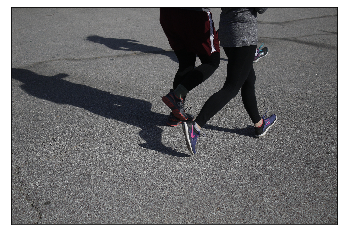

In [11]:
# fig = plt.figure(figsize=(16, 4))
for path in bad_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()